In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import random
import seaborn as sns
import pandas as pd

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA
device = "cpu"

# SCM

- The causal graph has three root nodes $X_1, X_2, X_3$ and each of these are connected to a descendant node $X_4$.

- The root nodes take on values from a Standard Gaussian distribution $\mathcal{N}(0, 1)$.

- For the internal node, we explore two kinds of structural equations:
    - **Linear** where $X_4 = w_1 X_1 + w_2 X_2 + w_3 X_3 + \epsilon_4$, and each $w_i \sim \mathcal{N}(0, 1)$
    - **Non-Linear** where $X_4 = \frac{\sin(X_1) + \sqrt{|X_2|} + \exp(-X_3)}{3} + \epsilon_4$. It is an average of three non-linear functions.

- $\epsilon_4$ is sampled from a Gaussian $\mathcal{N}(0, \sigma^2)$ with several different choices for the variance $\sigma^2$.


In [2]:
def non_y(X, var):
    assert X.shape[1] == 3, "Input array must be of shape 3"
    # Extract x, y, z from X
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    # Compute the non-linear function
    result = (np.sin(x) + np.sqrt(np.abs(y)) + np.exp(-z)) / 3
    exog = np.random.randn(len(X)) * np.sqrt(var)
    return [result.reshape(-1, 1), exog.reshape(-1, 1)]

def lin_y(X, w, var):
    assert X.shape[1] == 3, "Input array must be of shape 3"
    assert w.shape[0] == 3, "Weight array must be of shape 3"
    # Extract x, y, z from X
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    # Compute the linear function
    result = w[0] * x + w[1] * y + w[2] * z
    exog = np.random.randn(len(X)) * np.sqrt(var)
    return [result.reshape(-1, 1), exog.reshape(-1, 1)]

# Models

- For linear settings, we learn the function $f_4$ using a linear model using closed-form solution.
- For non-linear settings, we train a 3-layer ReLU based MLP

In [3]:
# %%
class LinearModel(nn.Module):
    def __init__(self, num_params):
        super(LinearModel, self).__init__()
        self.num_params = num_params

    def fit(self, X, y):
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        yhat = X @ self.w
        yhat = yhat.reshape(-1, 1)
        return yhat

    def forward(self, X):
        return self.predict(X)

class MLPModel(nn.Module):
    def __init__(self, num_params):
        super(MLPModel, self).__init__()
        self.num_params = num_params
        self.fc1 = nn.Linear(self.num_params, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.relu(X)
        X = self.fc2(X)
        return X.view(-1, 1)

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device=device)
        y = torch.tensor(y, dtype=torch.float32, device=device)
        self.to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-2)
        pbar = tqdm(range(1000))
        for _ in pbar:
            optimizer.zero_grad()
            yhat = self(X)
            loss = criterion(yhat.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()
            pbar.set_description(f"Loss: {loss.item()}")
            pbar.refresh()


    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=device)
        yhat = self(X)
        return yhat.detach().cpu().numpy()


# Experiment

We experiment with the following main hyperparameters for the Oracle SCM

- `variances = [0.5, 1, 2, 5]`
- `trn_sizes = [25, 50, 100, 1000]`

For each setting of the Oracle SCM, we learn the SCM by training $\hat{f_4}$ on the training samples. When training samples are large, we expect that $\hat{f_4}$ converges to the true SCM.

We assess four metrics:

- **Validation Error**: Measures the prediction accuracy of $\hat{f}_4$ on in-distribution data.
- **Test (RC) Error**: Measures the prediction accuracy on OOD samples
- **Counterfactual Error:** Quantifies the error arising from using CFs in place ot the true CF
- **Interventional Error:** Measures the error for using interventions in place opf the true CF


In [ ]:
# %% Set seed everytime you train models
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

Gauss = np.random.normal
results = {}
variances = [0.5, 1, 2, 5]
trn_sizes = [25, 50, 100, 1000]

# Sample the w for linear function
w = np.random.randn(3)

for var in  variances:
    results[var] = {}
    # %% Generate the same Val and Tst set for a fixed value of variance.
    XVal, XTst = Gauss(0, 1, (100, 3)), Gauss(0, 1, (100, 3))
    XFix = np.copy(XTst)

    # Generate the superset of all the training samples at once.
    AllXTrn = Gauss(0, 1, (50000, 3))

    # Inject root cause into the Testcases
    for i in range(len(XFix)):
        XTst[i, np.random.choice(3)] = np.random.uniform(3, 10) # This is the root cause

    y_dict = {
        "Val": {
            "lin": lin_y(XVal, w, var),
            "non": non_y(XVal, var)
        },
        "Tst": {
            "lin": lin_y(XTst, w, var),
            "non": non_y(XTst, var)
        },
        "Fix": {
            "lin": lin_y(XFix, w, var),
            "non": non_y(XFix, var)
        },
        "AllTrn": {
            "lin": lin_y(AllXTrn, w, var),
            "non": non_y(AllXTrn, var)
        }
    }

    # For the fix use the same exogenous variable as the test
    y_dict["Fix"]["lin"][1] = np.copy(y_dict["Tst"]["lin"][1])
    y_dict["Fix"]["non"][1] = np.copy(y_dict["Tst"]["non"][1])

    for size in trn_sizes:
        results[var][size] = {}

        error_keys = ["lin_val_error", "non_val_error", "lin_tst_error", "non_tst_error", "lin_int_error", "non_int_error", "lin_cf_error", "non_cf_error"]
        for key in error_keys:
            results[var][size][key] = []

        for run in [1, 2, 3, 4, 5]:
            # Take the first size samples for training
            XTrn = AllXTrn[:size]
            try:
                del y_dict["Trn"]
            except:
                pass
            y_dict["Trn"] = {
                "lin": [y_dict["AllTrn"]["lin"][0][:size], y_dict["AllTrn"]["lin"][1][:size]],
                "non": [y_dict["AllTrn"]["non"][0][:size], y_dict["AllTrn"]["non"][1][:size]]
            }

            # %% Fit the Models
            lin_model = LinearModel(3)
            non_model = MLPModel(3)

            lin_model.fit(XTrn, y_dict["Trn"]["lin"][0] + y_dict["Trn"]["lin"][1])
            non_model.fit(XTrn, y_dict["Trn"]["non"][0] + y_dict["Trn"]["non"][1])

            # %% Val Errors
            lin_val = lin_model.predict(XVal)
            non_val = non_model.predict(XVal)
            lin_val_res = (y_dict["Val"]["lin"][0] + y_dict["Val"]["lin"][1] - lin_val).reshape(-1, 1)
            non_val_res = (y_dict["Val"]["non"][0] + y_dict["Val"]["non"][1] - non_val).reshape(-1, 1)
            lin_val_error = np.mean((y_dict["Val"]["lin"][0] - lin_val)**2) # Just assess the f_4 prediction accuracies and not the X_4 on val data that has all usual parents.
            non_val_error = np.mean((y_dict["Val"]["non"][0] - non_val)**2)
            results[var][size]["lin_val_error"].append(lin_val_error)
            results[var][size]["non_val_error"].append(non_val_error)

            # %% Tst Errors
            lin_tst = lin_model.predict(XTst)
            non_tst = non_model.predict(XTst)
            lin_tst_res = (y_dict["Tst"]["lin"][0] + y_dict["Tst"]["lin"][1] - lin_tst).reshape(-1, 1)
            non_tst_res = (y_dict["Tst"]["non"][0] + y_dict["Tst"]["non"][1] - non_tst).reshape(-1, 1)

            # Just assess the f_4 prediction accuracies and not the X_4 on test data that has an abnormal a.k.a OOD parent.
            lin_tst_error = np.mean((y_dict["Tst"]["lin"][0] - lin_tst)**2)
            non_tst_error = np.mean((y_dict["Tst"]["non"][0] - non_tst)**2)
            results[var][size]["lin_tst_error"].append(lin_tst_error)
            results[var][size]["non_tst_error"].append(non_tst_error)

            # %% Int Error
            lin_int = lin_model.predict(XFix)
            non_int = non_model.predict(XFix)
            lin_int = (lin_int + np.mean(lin_val_res.squeeze())).reshape(-1, 1)
            non_int = (non_int + np.mean(non_val_res.squeeze())).reshape(-1, 1)
            lin_int_error = np.mean((y_dict["Fix"]["lin"][0] + y_dict["Fix"]["lin"][1] - lin_int)**2) # Assess the error between the true CD XFix_4 and the int estimate
            non_int_error = np.mean((y_dict["Fix"]["non"][0] + y_dict["Fix"]["non"][1] - non_int)**2)
            results[var][size]["lin_int_error"].append(lin_int_error)
            results[var][size]["non_int_error"].append(non_int_error)

            # %% CF Error
            lin_cf = lin_model.predict(XFix)
            non_cf = non_model.predict(XFix)
            lin_cf = lin_cf + lin_tst_res
            non_cf = non_cf + non_tst_res
            lin_cf_error = np.mean((y_dict["Fix"]["lin"][0] + y_dict["Fix"]["lin"][1] - lin_cf)**2)
            non_cf_error = np.mean((y_dict["Fix"]["non"][0] + y_dict["Fix"]["non"][1] - non_cf)**2)
            results[var][size]["lin_cf_error"].append(lin_cf_error)
            results[var][size]["non_cf_error"].append(non_cf_error)

        for key in error_keys:
            results[var][size][key] = np.mean(results[var][size][key])

In [ ]:
!pip install xlsxwriter

In [ ]:
import pandas as pd
xlwriter = pd.ExcelWriter('limitations.xlsx', engine='xlsxwriter')
cols = ['lin_val_error', 'non_val_error', 'lin_tst_error', 'non_tst_error', 'lin_int_error', 'non_int_error', 'lin_cf_error', 'non_cf_error']
for var in results.keys():
    df = {}
    for col in cols:
        df[col] = []
        for size in trn_sizes:
            df[col].append(results[var][size][col])
    df = pd.DataFrame(df)
    df.index = trn_sizes
    df.to_excel(xlwriter, sheet_name=f"var={var}")
    print(f"Wrote {var}")
xlwriter.close()

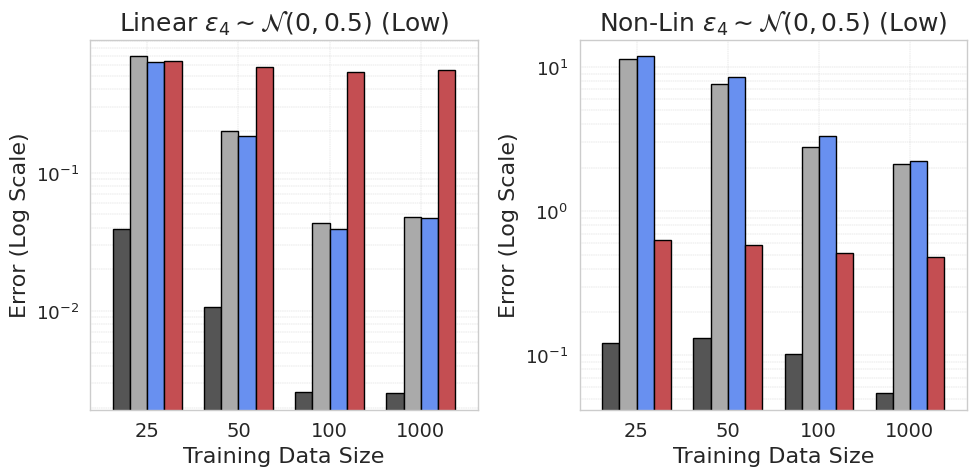

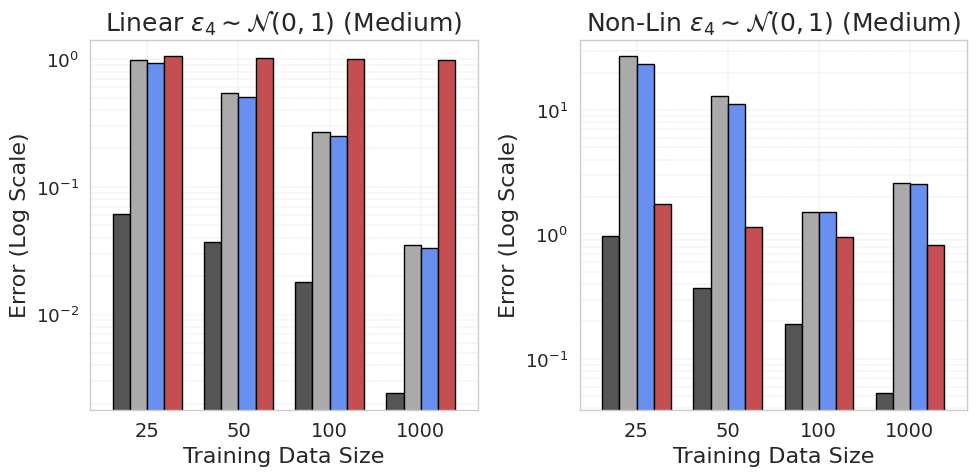

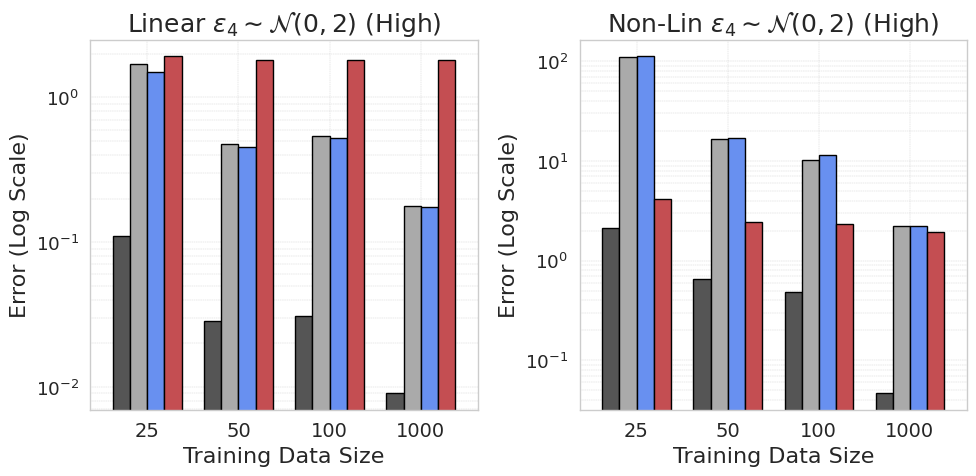

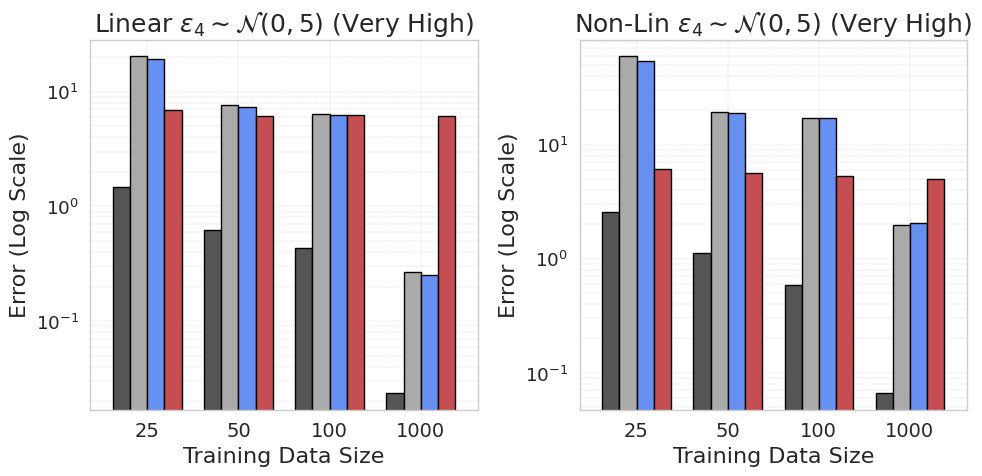

In [7]:
import matplotlib.pyplot as plt
var_dict = {
    0.5: "Low",
    1: "Medium",
    2: "High",
    5: "Very High"
}
title_size = 18
label_size = 16
tick_size = 14
xlbook = 'limitations.xlsx'
for idx, var in enumerate(variances):
    # plt.clf()
    # plt.cla()
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.5)

    df = pd.read_excel(xlbook, sheet_name=f"var={var}")
    lin_bars = ["lin_val_error", "lin_tst_error", "lin_cf_error", "lin_int_error"]
    non_bars = ["non_val_error", "non_tst_error", "non_cf_error", "non_int_error"]

    lin_bars_name = ["Validation", "Test", "Counterfactual",  "Intervention"]
    non_bars_name = ["Validation", "Test", "Counterfactual", "Intervention"]

    # bar_colors =  ['#1b9e77', '#fdaa48','#6890F0', 'r']
    bar_colors = ['#555555', '#aaaaaa', '#6890F0', 'r']
    bar_line_width = 1
    bar_width = 0.75

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    df[lin_bars].plot(kind='bar', ax=ax[0], color=bar_colors, linewidth=bar_line_width, width=bar_width, edgecolor='black')
    ax[0].set_title(r'Linear $\epsilon_4 \sim {}(0, {})$ ({})'.format("\mathcal{N}", var, var_dict[var]), fontsize=title_size)
    ax[0].set_xlabel("Training Data Size", fontsize=label_size)
    ax[0].set_ylabel("Error (Log Scale)", fontsize=label_size)
    ax[0].set_yscale('log')
    ax[0].set_xticklabels(trn_sizes, rotation=0, fontsize=tick_size)
    ax[0].legend().set_visible(False)
    ax[0].grid(True, which='both', linestyle='--', lw=0.3)

    df[non_bars].plot(kind='bar', ax=ax[1], color=bar_colors, linewidth=bar_line_width, width=bar_width, edgecolor='black')
    ax[1].set_title(r'Non-Lin $\epsilon_4 \sim {}(0, {})$ ({})'.format("\mathcal{N}", var, var_dict[var]), fontsize=title_size)
    ax[1].set_xlabel("Training Data Size", fontsize=label_size)
    ax[1].set_ylabel("Error (Log Scale)", fontsize=label_size)
    ax[1].set_yscale('log')
    ax[1].set_xticklabels(trn_sizes, rotation=0, fontsize=tick_size)
    ax[1].legend().set_visible(False)
    ax[1].grid(True, which='both', linestyle='--', lw=0.3)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"toy_{idx+1}.pdf")

# Export Legend

/tmp/ipykernel_909183/2138436427.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [mpatches.Patch(color=color, label=label, edgecolor='black', linewidth=1)


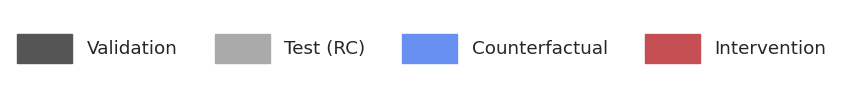

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define colors and labels
bar_colors = ['#555555', '#aaaaaa', '#6890F0', 'r']
bars_name = ["Validation", "Test (RC)", "Counterfactual", "Intervention"]

# Create a dummy figure
fig, ax = plt.subplots(figsize=(6, 1))
ax.set_axis_off()  # Hide the axis

# Create legend patches with rectangular bars
legend_patches = [mpatches.Patch(color=color, label=label, edgecolor='black', linewidth=1) 
                  for color, label in zip(bar_colors, bars_name)]

# Create legend with wider bars
legend = ax.legend(handles=legend_patches, loc='center', ncol=4, frameon=False,
                   handleheight=2.0, handlelength=3.0)  # Adjust bar height and width

# Save legend separately as a PDF
fig.savefig("toy_legend.pdf", bbox_inches='tight', dpi=300, transparent=True)

plt.show()
